# 3MD4120: Reinforcement Learning - Individual Assignment 

This notebook showcases 2 agents: Monte Carlo agent and Sarsa($\lambda$) agent. It is organised as follows:
- Imports
- Visualisation functions
- Environment initialisation
- Agent implementations
    - Monte Carlo agent
        - Helper functions
        - Experiment
        - Hyperparameter sweeping
    - Sarsa($\lambda$) agent
        - Helper functions
        - Experiment
        - Hyperparameter sweeping
- Policy visualisation
- Visualing a game play
- Evaluating the policy of trained agents on the TFB environment with a different configuration
    - New environment configuration
    - Evaluating the Monte Carlo agent
    - Evaluating the Sarsa($\lambda$) agent

# Imports & seeds

In [23]:
import os, sys
import time
import tqdm
import numpy as np
from collections import defaultdict, deque
import gymnasium as gym
import wandb
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import text_flappy_bird_gym

# Environment initialisation

In [24]:
# initiate environment
# returns the horizontal and vertical distance of the player to the closest upcoming pipe gap
height = 15
width = 20
pipe_gap = 4
env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)

# Agent implementation

## Monte-Carlo agent

### Helper functions

In [25]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()[0]
    i_step = 0
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[tuple(state)], epsilon, nA)) \
                                    if tuple(state) in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done, _, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done or i_step > 2000:
            break
        i_step += 1
    return (episode, info['score'])

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)

    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

### Experiments

In [26]:
def mc_control(env, num_episodes, alpha, gamma=0.9, eps_start=1.0, eps_decay=.999, eps_min=0.0, sweeping=False):
    """ 
    Control agent using on-policy first-visit MC control.
    """
    nA = env.action_space.n 
    epsilon = eps_start
    Q = defaultdict(lambda: np.zeros(nA))

    # only the last 50 episode rewards are stored in the moving_average buffer
    score_buffer = deque(maxlen=100) 
    reward_buffer = deque(maxlen=1500)

    for i_episode in range(1, num_episodes+1):

        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)

        # generate an episode by following epsilon-greedy policy
        episode, score = generate_episode_from_Q(env, Q, epsilon, nA)

        # store the score of the episode
        score_buffer.append(score)
        # store the sum of rewards of the episode
        sum_episode_rewards = np.sum([r for _, _, r in episode])
        reward_buffer.append(sum_episode_rewards)

        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma) 

        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}, smoothed score = {}.".format(i_episode, num_episodes, np.mean(score_buffer), end=""))

        wandb.log({'reward': sum_episode_rewards}) if sweeping else None

    wandb.log({'smoothed_score': np.mean(score_buffer), 'average_reward': np.mean(reward_buffer)}) if sweeping else None
    
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [27]:
policy_mc, Q_mc = mc_control(env, 6000, 0.02, gamma = 0.99, eps_decay=0.999)

Episode 1000/6000, smoothed score = 1.42.
Episode 2000/6000, smoothed score = 5.3.
Episode 3000/6000, smoothed score = 15.94.
Episode 4000/6000, smoothed score = 40.82.
Episode 5000/6000, smoothed score = 96.0.
Episode 6000/6000, smoothed score = 152.47.


### Hyperparameter tuning 

In [ ]:
sweep_configuration = {
    "name": "RL_FlappyBird",
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "average_reward"},
    "parameters": {
        "epsilon_decay": {"distribution": 'inv_log_uniform_values', "min": 0.9, "max": 0.9999},
        "alpha": {"distribution": 'log_uniform_values', "min": 0.001, "max": 0.1},
        "gamma": {"min": 0.5, "max": 0.999},
    },
}

def run_sweeping():
    wandb.init(project="RL-FlappyBird")
    eps_decay = wandb.config.epsilon_decay
    alpha = wandb.config.alpha
    gamma = wandb.config.gamma
    mc_control(env, 6000, alpha, gamma, eps_decay, sweeping=True)

sweep_id = wandb.sweep(sweep=sweep_configuration, project="RL-FlappyBird")
wandb.agent(sweep_id, function=run_sweeping, count=20)

### Visualisation

In [28]:
def plot_flappybird_values(V):

    def get_Z(x, y):
        if (x,y) in V:
            return V[(x,y)]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(0, 15)
        y_range = np.arange(1, 20)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-0.1, vmax=30)
        ax.set_xlabel('Horizontal distance player - pipe gap center X')
        ax.set_ylabel('Vertical distance player - pipe gap center Y')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, 70)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('State value function V(s) - Flappy Bird')
    get_figure(True, ax)
    plt.show()


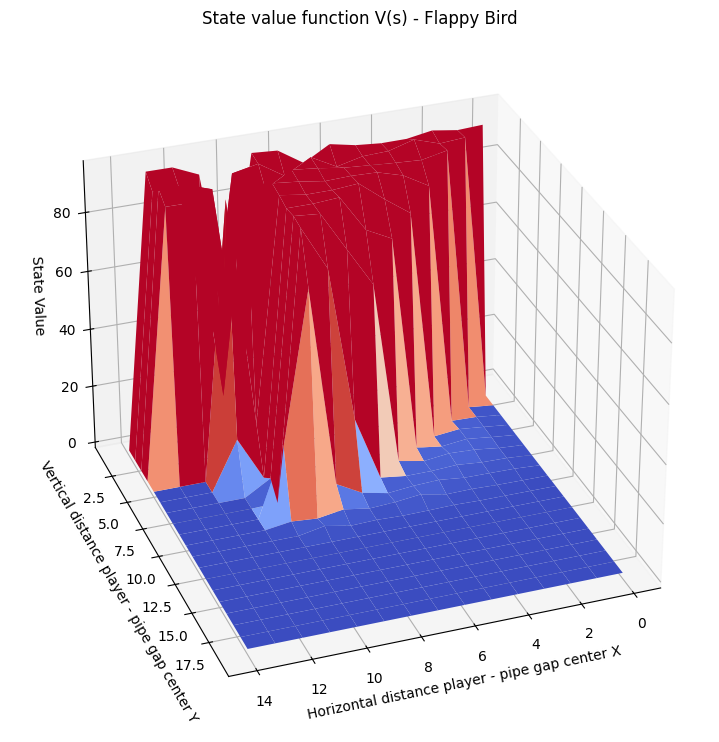

In [29]:
V = dict((k,np.max(v)) for k, v in Q_mc.items())

# plot the state-value function
plot_flappybird_values(V)

## Sarsa($\lambda$) agent

### Experiments

In [30]:
def sarsa_lambda_control(env, num_episodes, alpha, trace_decay, gamma=1.0, eps_start=1.0, eps_decay=.999, eps_min=0.0, sweeping=False):
    """ 
    Control agent using on-policy first-visit MC control.
    """
    nA = env.action_space.n 
    epsilon = eps_start
    Q = defaultdict(lambda: np.zeros(nA))
    eligibility_trace = defaultdict(lambda: np.zeros(nA))


    # only the last 50 episode rewards are stored in the moving_average buffer
    score_buffer = deque(maxlen=100) 
    reward_buffer = deque(maxlen=1500)

    for i_episode in range(1, num_episodes+1):

        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)

        state = env.reset()[0]
        action = np.random.choice(np.arange(nA), p=get_probs(Q[tuple(state)], epsilon, nA)) \
                                    if tuple(state) in Q else env.action_space.sample()
        
        # Reset eligibility trace
        eligibility_trace = defaultdict(lambda: np.zeros(nA))
        
        ep_reward = []
        i_step = 0
        while True:
            next_state, reward, done, _, info = env.step(action)
            ep_reward.append(reward)

            next_action = np.random.choice(np.arange(nA), p=get_probs(Q[tuple(next_state)], epsilon, nA)) \
                                    if tuple(next_state) in Q else env.action_space.sample()

            # compute TD error
            td_target = reward + Q[tuple(next_state)][next_action]
            td_error = td_target - Q[tuple(state)][action]

            # Accumulating traces
            eligibility_trace[tuple(state)][action] += 1 

            if done or i_step > 2000:
                break
            i_step += 1

            # update the action-value function estimate using the episode
            for s in Q.keys():
                for a in range(nA):
                    Q[s][a] += alpha * td_error * eligibility_trace[s][a]
                    eligibility_trace[s][a] *= gamma*trace_decay

            state = next_state
            action = next_action

        score_buffer.append(info['score'])

        # store the sum of rewards of the episode
        sum_episode_rewards = np.sum(ep_reward)
        reward_buffer.append(sum_episode_rewards)

        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}, smoothed score = {}.".format(i_episode, num_episodes, np.mean(score_buffer), end=""))


        wandb.log({'reward': sum_episode_rewards}) if sweeping else None

    wandb.log({'smoothed_score': np.mean(score_buffer), 'average_reward': np.mean(reward_buffer)}) if sweeping else None

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [31]:
policy_sarsa_lam, Q_sarsa_lam = sarsa_lambda_control(env, 6000, 0.03, gamma = 0.95, eps_decay=0.999, trace_decay = 0.98)

Episode 1000/6000, smoothed score = 1.37.
Episode 2000/6000, smoothed score = 4.73.
Episode 3000/6000, smoothed score = 8.53.
Episode 4000/6000, smoothed score = 13.61.
Episode 5000/6000, smoothed score = 13.32.
Episode 6000/6000, smoothed score = 15.32.


### Hyperparameter tuning

In [ ]:
sweep_configuration = {
    "name": "RL_FlappyBird2",
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "average_reward"},
    "parameters": {
        "epsilon_decay": {"distribution": 'inv_log_uniform_values', "min": 0.9, "max": 0.9999},
        "alpha": {"distribution": 'log_uniform_values', "min": 0.001, "max": 0.1},
        "trace_decay": {"distribution": 'inv_log_uniform_values', "min": 0.9, "max": 0.9999},
        "gamma": {"distribution": 'inv_log_uniform_values', "min": 0.8, "max": 0.999},
    },
}

def run_sweeping():
    wandb.init(project="RL-FlappyBird2")
    eps_decay = wandb.config.epsilon_decay
    alpha = wandb.config.alpha
    trace_decay = wandb.config.trace_decay
    gamma = wandb.config.gamma
    sarsa_lambda_control(env, 4000, alpha=alpha, trace_decay=trace_decay, gamma=gamma, eps_decay=eps_decay, sweeping=True)

sweep_id = wandb.sweep(sweep=sweep_configuration, project="RL-FlappyBird2")
wandb.agent(sweep_id, function=run_sweeping, count=20)

## Policy visualisation

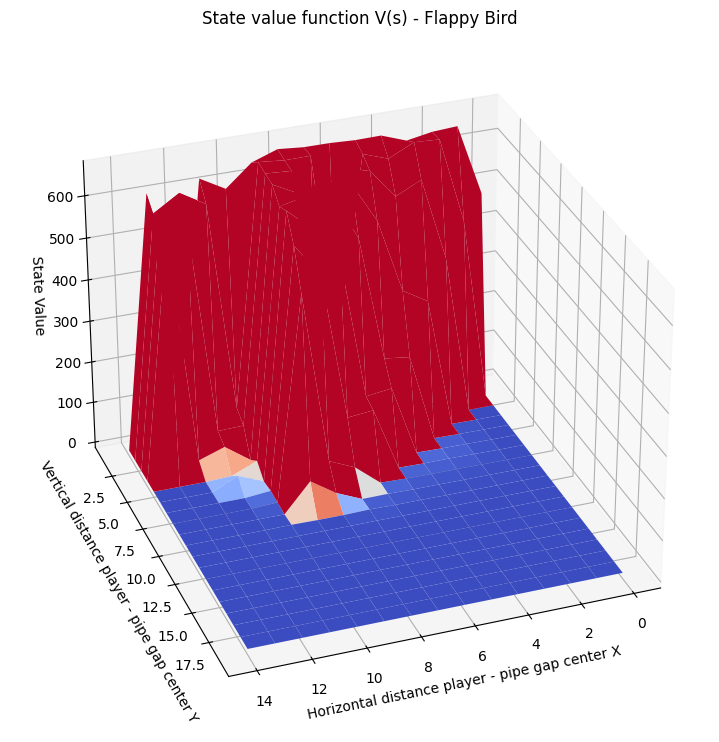

In [32]:
V = dict((k,np.max(v)) for k, v in Q_sarsa_lam.items())

# plot the state-value function
plot_flappybird_values(V)

## Visualising a game play

In [ ]:
obs = env.reset()[0]

# iterate
n_step = 1000
for i in range(n_step):

    # Select next action
    action = policy_mc[obs]

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS


    # If player is dead break
    if done:
        break

    env.close()

## Evaluating the policy of trained agents on the TFB environment with a different configuration

### New environment configuration

In [ ]:
height = 25 # instead of 15
width = 25 # instead of 20
pipe_gap = 3 # instead of 4
env = gym.make('TextFlappyBird-v0', height = height, width = width, pipe_gap = pipe_gap)

### Evaluation of the Monte Carlo agent

In [ ]:
obs = env.reset()[0]

# iterate
n_step = 1000
for i in range(n_step):

    # Select next action
    if obs not in policy_mc: # as the environment is different, the policy may not be defined for all states
        action = env.action_space.sample()
    else:
        action = policy_mc[obs]

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

### Evaluation of the Sarsa($\lambda$) agent

In [ ]:
obs = env.reset()[0]

# iterate
n_step = 1000
for i in range(n_step):

    # Select next action
    if obs not in policy_sarsa_lam: # as the environment is different, the policy may not be defined for all states
        action = env.action_space.sample()
    else:
        action = policy_sarsa_lam[obs]

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS